#  Web Scraping
### Finding Underpriced RVs on Craigslist

In this Notebook I will be practicing my web scraping skills from both Wikipedia and Craigslist

![](https://snag.gy/WrdUMx.jpg)

In [1]:
# PREPARE REQUIRED LIBRARIES
from scrapy.selector import Selector
from scrapy.http import HtmlResponse
from bs4 import BeautifulSoup
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

### Scrape Wikipedia for the largest US cities (non-exhaustive list)

In [2]:
# URL & REQUEST
url = "https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population"
response = requests.get(url)

# XPATH AND EXTRACT
xpath_expression = "//div[@class='gallerytext']/a[1]/@title"
cities = Selector(text=response.text).xpath(xpath_expression).extract()

In [3]:
print cities[:10]
print
print 'Number of Cities:', len(cities)

[u'New York City', u'Los Angeles', u'Chicago', u'Houston', u'Philadelphia', u'Phoenix, Arizona', u'San Antonio', u'San Diego', u'Dallas', u'San Jose, California']

Number of Cities: 50


###  Writing a function to capture current pricing information via Craigslist in a city.

In [4]:
def rv_prices(city="losangeles", DataFrame=True):
    
    # URL & REQUEST
    url = "https://%s.craigslist.org/search/cta?query=rv" % city
    response = requests.get(url)
    
    # PRICES, TITLE xpath
    xpath_price = "//li[@class='result-row']/p[@class='result-info']/span[@class='result-meta']/span[@class='result-price']/text()"
    xpath_title = "//li[@class='result-row']/p[@class='result-info']/a[@class='result-title hdrlnk']/text()"

    # EXTRACTING TEXT
    titles = Selector(text=response.text).xpath(xpath_title).extract()
    prices = Selector(text=response.text).xpath(xpath_price).extract()
    
    # DATAFRAME of title & prices
    rv_prices = pd.DataFrame(zip(titles, prices), columns=['title', 'price_usd'])
    
    if DataFrame:
        return rv_prices
    else:
        return rv_prices.price_usd.apply(lambda x: int(x.replace('$', '')))

In [5]:
rv_prices().head()

,title,price_usd
0,1977 rv van tradesman,$3500
1,You got RV or cash?,$2
2,1978 van tradesman rv,$3500
3,MERCEDES 3500 EXTended RV,$95000
4,1960 Chevy corvair trade for RV VW bug bus baja,$1


In [6]:
rv_prices(DataFrame=False)[:5]

0     3500
1        2
2     3500
3    95000
4        1
Name: price_usd, dtype: int64

### Mapping of cities to regional Craigslist URLs

In [7]:
cities[:10]

[u'New York City',
 u'Los Angeles',
 u'Chicago',
 u'Houston',
 u'Philadelphia',
 u'Phoenix, Arizona',
 u'San Antonio',
 u'San Diego',
 u'Dallas',
 u'San Jose, California']

In [8]:
craig_city = ['newyork', 'losangeles', 'chicago', 'houston', 'philadelphia', 
              'phoenix', 'sanantonio', 'sandiego', 'dallas', 'sfbay']

In [9]:
def city_url_dict(city_li, url_li):  
    pair = zip(city_li, url_li)
    dct = {}  
    for item in pair:  
        dct[item[0]] = item[1]
    return dct  

In [10]:
city_url_map = city_url_dict(cities[:10], craig_city)

In [11]:
city_url_map

{u'Chicago': 'chicago',
 u'Dallas': 'dallas',
 u'Houston': 'houston',
 u'Los Angeles': 'losangeles',
 u'New York City': 'newyork',
 u'Philadelphia': 'philadelphia',
 u'Phoenix, Arizona': 'phoenix',
 u'San Antonio': 'sanantonio',
 u'San Diego': 'sandiego',
 u'San Jose, California': 'sfbay'}

### Defining a function to caculate mean and median price per city.

In [12]:
for idx, val in city_url_map.items():
    print idx, val, 'https://%s.craigslist.org/search/sss?query=rv' % val

Houston houston https://houston.craigslist.org/search/sss?query=rv
Chicago chicago https://chicago.craigslist.org/search/sss?query=rv
New York City newyork https://newyork.craigslist.org/search/sss?query=rv
San Diego sandiego https://sandiego.craigslist.org/search/sss?query=rv
Philadelphia philadelphia https://philadelphia.craigslist.org/search/sss?query=rv
Phoenix, Arizona phoenix https://phoenix.craigslist.org/search/sss?query=rv
Dallas dallas https://dallas.craigslist.org/search/sss?query=rv
San Jose, California sfbay https://sfbay.craigslist.org/search/sss?query=rv
Los Angeles losangeles https://losangeles.craigslist.org/search/sss?query=rv
San Antonio sanantonio https://sanantonio.craigslist.org/search/sss?query=rv


In [13]:
def price_summary(prices):
    mean = round(np.mean(prices), 2)
    med = round(np.median(prices), 2)
    return (mean, med)

In [14]:
def city_rv_prices(city_url_map=city_url_map):
    
    summary = [] # EMPTY LIST TO HOLD CITY PRICE DATA
    
    for idx, val in city_url_map.items():

        prices = rv_prices(city=val, DataFrame=False) # GET RV PRICES
        price_tup = price_summary(prices) # (MEAN, MEDIAN)

        summary.append((idx, price_tup[0], price_tup[1])) # ADD PRICE DATA TO LIST
        
    return pd.DataFrame(summary, columns=['city', 'mean_price', 'med_price'])

**Saving results to csv**

In [15]:
df = city_rv_prices(city_url_map)

In [16]:
df

,city,mean_price,med_price
0,Houston,9317.65,5000.0
1,Chicago,11567.55,8900.0
2,New York City,10108.01,7250.0
3,San Diego,23306.85,7450.0
4,Philadelphia,15700.90,9700.0
5,"Phoenix, Arizona",13526.24,7500.0
6,Dallas,18366.59,16000.0
7,"San Jose, California",20771.05,11500.0
8,Los Angeles,18145.98,6499.0
9,San Antonio,16306.05,12488.0


In [17]:
df.to_csv('city_rvs') # SAVING FILE TO CSV

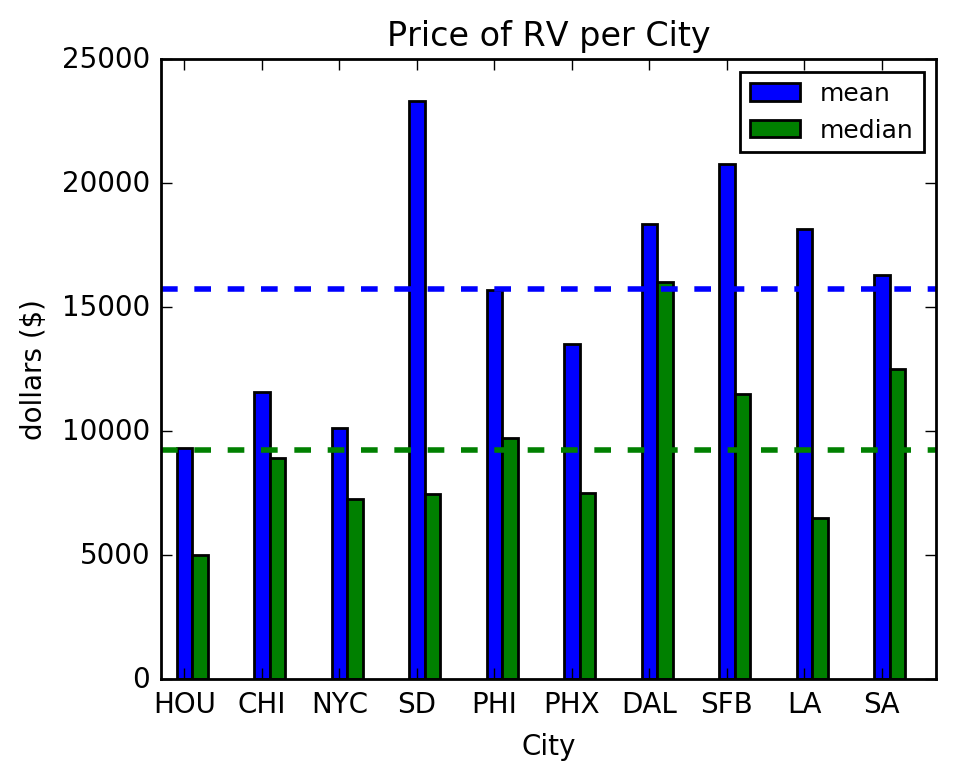

In [18]:
x = np.arange(df.shape[0])
y = df.mean_price.values # mean_prices
z = df.med_price.values # med_prices

lbl = ['HOU', 'CHI', 'NYC', 'SD', 'PHI', 'PHX', 'DAL', 'SFB', 'LA', 'SA']

fig = plt.figure(figsize=(5,4))
ax = fig.gca()
ax = plt.subplot(111)

ax.bar(x-0.2, y,width=0.2,color='b',align='center', label='mean', tick_label=lbl)
ax.bar(x, z,width=0.2,color='g',align='center', label='median')

# ax.set_xticklabels(df.city, rotation=45, rotation_mode="anchor")

ax.set_xlabel('City')
ax.set_ylabel('dollars ($)')
ax.set_title('Price of RV per City')

ax.set_xlim(-0.5, df.shape[0] - 0.5)

ax.axhline(np.mean(df.mean_price), lw=2, ls='dashed', color='blue')
ax.axhline(np.mean(df.med_price), lw=2, ls='dashed', color='green')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=9)

plt.show()

### Does it makes sense to buy RVs in one region and sell them in another?

Assuming the cost of shipping or driving from one regional market to another.

_Eyeballing the data I see that you can profit a few thousand dollars by buying in one region and selling in a nearby one. For example, NYC rvs can be sold in Philadelphia for a \$3,000 to \$5,000 profit minus expenses. Same thing holds for Los Angeles RVs being sold in the Bay Area._